# H2O predict the LLM

- Count Vectorizer + XGBoost

In [38]:
# imports 
import pandas as pd
import numpy as np
import spacy
import string

# set the random seed
np.random.seed(1313)


In [4]:
# data
data = pd.read_csv("/kaggle/input/h2oai-predict-the-llm/train.csv")
data.head()

    
    

,Question,Response,target
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3976 entries, 0 to 3975
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  3976 non-null   object
 1   Response  3969 non-null   object
 2   target    3976 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 93.3+ KB


In [31]:
data.isna().sum()

Question    0
Response    7
target      0
dtype: int64

In [35]:
data = data.dropna()

In [36]:
# target distribution
np.bincount(data.target)

array([566, 565, 567, 568, 568, 568, 567])

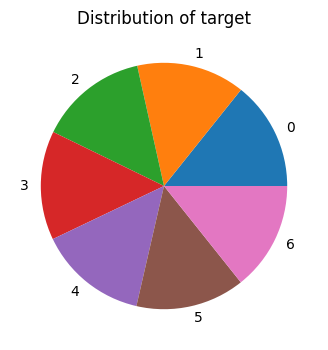

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize = (4,4))
plt.pie(np.bincount(data.target), labels = np.arange(7))
plt.title("Distribution of target")
plt.show()

In [41]:
# initialize the scapy model

nlp = spacy.load('en_core_web_sm')
stopwords = nlp.Defaults.stop_words
punctuation = string.punctuation

In [56]:
def spacy_tokenizer(sentence):
    if type(sentence) == float:
        sentence = sentence
    else:
        docs = nlp(sentence)
        mytokens = [word.lemma_.lower().strip() for word in docs]
        mytokens = [word for word in mytokens if word not in stopwords and word not in punctuation]
        sentence = ' '.join(mytokens)
    return sentence
        

In [57]:
data['tokenized_Question'] = data['Question'].apply(spacy_tokenizer)
data['tokenized_Response'] = data["Response"].apply(spacy_tokenizer)


In [58]:
data.head()

,Question,Response,target,tokenized_Question,tokenized_Response
0,Explain the concept of coevolution.,Coevolution is a biological process that occur...,3,explain concept coevolution,coevolution biological process occur specie ev...
1,Is it possible that recurring fever and chills...,"Yes, recurring fever and chills can be a sympt...",4,possible recur fever chill indicate malaria,yes recur fever chill symptom malaria especial...
2,Evaluate the expression 3!,The expression 3! represents the factorial of ...,1,evaluate expression 3,expression 3 represent factorial 3 product pos...
3,What are the roles of different types of RNA i...,1. Messenger RNA (mRNA): mRNA carries genetic ...,3,role different type rna cell,1 messenger rna mrna ): mrna carry genetic inf...
4,What is the role of gene flow in population ge...,Gene flow refers to the movement of individual...,3,role gene flow population genetic,gene flow refer movement individual population...


In [59]:
data.loc[0].tokenized_Response

'coevolution biological process occur specie evolve time mean specie change response change lead close complex relationship example process coevolution observe relationship plant pollinator like bee butterfly flower evolve attract specific type insect pollination example change scent shape petal insect turn evolve trait reach collect nectar flower like long tongue specialized eye structure coevolution involve predator prey species adapt counteract adaptation instance cheetah speed agility evolve catch prey antelope ability run fast spot predator afar evolve response process lead race specie try stay ahead adaptation close relationship form result lead mutualism specie benefit endosymbiosis specie live inside overall coevolution play significant role shape diversity complexity life earth'

In [62]:
x = data.iloc[:,3:]
y = data.iloc[:, 2]

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

vec1 = CountVectorizer()
vec2 = CountVectorizer()


X_vec1 = vec1.fit_transform(x.iloc[:,0])
X_vec2 = vec2.fit_transform(x.iloc[:,1])


In [67]:
from scipy.sparse import hstack

X_vec = hstack((X_vec1, X_vec2))

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_vec, y, test_size = 0.2, stratify = y)


In [98]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_vec, y)
#pred = log_reg.predict(x_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [82]:
from sklearn.metrics import classification_report
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.25      0.31      0.28        89
           1       0.26      0.26      0.26       111
           2       0.11      0.14      0.12        86
           3       0.52      0.56      0.54       106
           4       0.27      0.22      0.25       138
           5       0.26      0.39      0.31        77
           6       0.47      0.28      0.35       187

    accuracy                           0.30       794
   macro avg       0.30      0.31      0.30       794
weighted avg       0.33      0.30      0.31       794



In [83]:
test_data = pd.read_csv('/kaggle/input/h2oai-predict-the-llm/test.csv')
test_data.head()

,id,Question,Response
0,0,Multiply 13 by 7.,Multiplying 13 by 7 gives a result of 64.\nThe...
1,1,Who were the main protagonists in the Hundred ...,The most important characters in this war incl...
2,2,What was the importance of the Truman Doctrine?,"The Truman Doctrine, also known as the United ..."
3,3,Which film features a character named Jack Ske...,The Nightmare Before Christmas
4,4,What are the components of the cytoskeleton?,"The cytoskeleton, which provides the framework..."


In [85]:
test_data['tokenized_Question'] = test_data['Question'].apply(spacy_tokenizer)
test_data['tokenized_Response'] = test_data['Response'].apply(spacy_tokenizer)



In [87]:
test_data[test_data['tokenized_Question'].isna()]

,id,Question,Response,tokenized_Question,tokenized_Response


In [88]:
test_data[test_data['tokenized_Response'].isna()]

,id,Question,Response,tokenized_Question,tokenized_Response
446,446,I have seven letters and am something you eat....,NaN,seven letter eat anagram help pain remove lett...,NaN
969,969,What was the impact of the fall of Constantino...,NaN,impact fall constantinople europe,NaN


In [89]:
test_data.iloc[446,3] = ''
test_data.iloc[446,4] = ''
test_data.iloc[969,3] = ''
test_data.iloc[969,4] = ''



In [91]:
test_vec1 = vec1.transform(test_data['tokenized_Question'])
test_vec2 = vec2.transform(test_data['tokenized_Response'])

test_vec = hstack((test_vec1, test_vec2))


In [99]:
sub_df = pd.read_csv("/kaggle/input/h2oai-predict-the-llm/sample_submission.csv")

for i in range(len(sub_df)):
    output_arr = xgb.predict_proba(test_vec[i])
    sub_df.iloc[i,1] = output_arr[0][0]
    sub_df.iloc[i,2] = output_arr[0][1]
    sub_df.iloc[i,3] = output_arr[0][2]
    sub_df.iloc[i,4] = output_arr[0][3]
    sub_df.iloc[i,5] = output_arr[0][4]
    sub_df.iloc[i,6] = output_arr[0][5]
    sub_df.iloc[i,7] = output_arr[0][6]
    

In [100]:
sub_df

,id,target_0,target_1,target_2,target_3,target_4,target_5,target_6
0,0,0.488433,0.074336,0.061112,0.011496,0.066728,0.221428,0.076468
1,1,0.153880,0.120182,0.168397,0.021087,0.333742,0.055159,0.147553
2,2,0.094342,0.083539,0.132203,0.135525,0.099632,0.142347,0.312414
3,3,0.184228,0.050519,0.186794,0.013396,0.221133,0.085559,0.258371
4,4,0.069341,0.010072,0.041899,0.830746,0.003557,0.006792,0.037594
...,...,...,...,...,...,...,...,...
996,996,0.204065,0.196117,0.206907,0.063641,0.126656,0.062735,0.139878
997,997,0.127251,0.169724,0.050739,0.090712,0.086439,0.199032,0.276103
998,998,0.086691,0.037792,0.264648,0.034712,0.358357,0.147786,0.070015
999,999,0.180535,0.034666,0.212417,0.036265,0.224760,0.236835,0.074523


In [101]:
sub_df.to_csv('submission.csv', index = False)